In [22]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy
from scipy.linalg import cholesky, cho_solve, solve_triangular
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import GPy as gpy
import GPy
import scipy.integrate as integrate


In [23]:
def normal(s):
    return scipy.stats.norm(0.0, np.sqrt(1.0)).pdf(s)

(100, 2) (100, 1)


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,0.0,+ve,


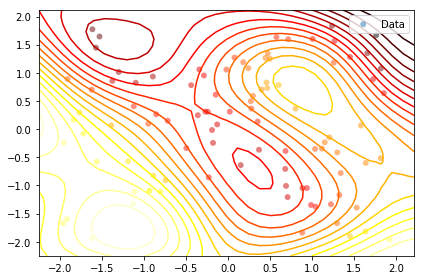

In [65]:
def sample_function(x_range, N=100, seed=4):
#     np.random.seed(seed)
    dx = x_range.shape[1]
    k = gpy.kern.src.rbf.RBF(input_dim=dx,lengthscale=1.0)
    x = np.random.uniform(x_range[0], x_range[1], (N, dx))
    cov = k.K(x, x)
    mu = np.zeros(x.shape[0])
#     y = np.atleast_2d(normal(x[:,1])).T
    y = np.random.multivariate_normal(np.squeeze(mu), cov)[:, None]
    print x.shape, y.shape
    m = gpy.models.GPRegression(x, y, k)#, mean_function=mean)
    m.likelihood.variance = 0.0

    def f(x): return m.predict(x)[0]
    return f,m
x_range = np.array([[-2.0,-2.0], [2.0,2.0]])
f,m = sample_function(x_range)
m.plot()
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,0.0,+ve,


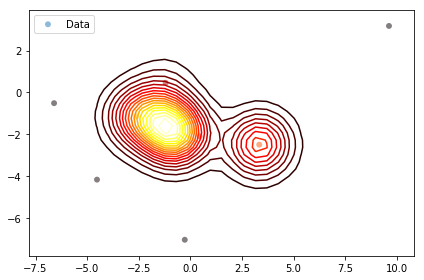

In [95]:
# k = GPy.kern.src.rbf.RBF(input_dim=1,lengthscale=0.1)
# kernel = RBF(1.0, (1e-2, 1e2))
x = np.random.normal(0,4,(10,2))
y = f(x)
gp = GPy.models.GPRegression(x, y, GPy.kern.src.rbf.RBF(input_dim=2,lengthscale=1.0),noise_var=0.0)
gp.plot()
gp

In [67]:
u,v = gp.predict(np.array([[0.3,0.3]]))
print u, v

def get_mean_func(gp):
    def f(x):
        Kxpx = gp.kern.K(x,gp.X)
        return np.dot(Kxpx,gp.posterior.woodbury_vector)
    return f

def get_cov_func(gp):
    def f(x,y):
        Kxy = gp.kern.K(x,y)
        K1 = gp.kern.K(x,gp.X)
        K2 = gp.kern.K(gp.X,y)
        return Kxy - K1.dot(gp.posterior.woodbury_inv.dot(K2))
    return lambda x,y: f(x,y)

# cov1 = lambda x,y: gp.kern.K(np.array([[x]]),np.array([[y]]))
# cov2 = (lambda x,y: gp.kern.K(np.array([[x]]),gp.X).dot(gp.posterior.woodbury_inv.dot(gp.kern.K(gp.X,np.array([[y]])))))

print get_mean_func(gp)(np.array([[0.3,0.3]]))
print get_cov_func(gp)(np.array([[0.3,0.3]]),np.array([[0.3,0.3]]))
# print cov1(0.3,0.3) - cov2(0.3,0.3)
# gp.predict(np.array([[0.3]]))[0][0][0]

[[-0.01713947]] [[0.94486127]]
[[-0.01713947]]
[[0.94486127]]


In [68]:
b = np.array([0.0])
B = np.array([[1.0]])
def bintegrate(gp,b,B):
    n,dim = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(dim))
    I = np.identity(dim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :]
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0]
bintegrate(m,b,B)

ValueError: shapes (2,2) and (1,1) not aligned: 2 (dim 1) != 1 (dim 0)

In [97]:
b = np.array([0.0])
B = np.array([[1.0]])
def integrate_dim(gp, sdim,a,b, B):
    n,_ = gp.X.shape
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    z = np.zeros((n, 1))
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    for i in range(n):
        x = X[i, :sdim]
        xa = X[i, sdim:]
        factor = np.exp(-0.5 * np.sum((xa-a)**2 / (length_scale ** 2)))
        expon = np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        z[i, :] = factor*determ * expon
    mean = np.dot(z.T,gp.posterior.woodbury_vector)
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    var = var_determ - np.dot(z.T, gp.posterior.woodbury_inv.dot(z))
    return mean[0][0], var[0][0], z
_,_,z =  integrate_dim(gp,1,np.array([0.0]),b,B)


def bq_acquisition(gp,sdim,a,b,B,xs,z):
    length_scale = gp.kern.lengthscale[0]
    A = length_scale** 2 * np.diag(np.ones(sdim))
    I = np.identity(sdim)    
    X = gp.X
    
    var_determ = np.linalg.det(2*np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    determ = np.linalg.det(np.dot(np.linalg.inv(A), B) + I) ** (-0.5)
    abinv = np.linalg.inv(A + B)
    variances = np.zeros((xs.shape[0]))
    for i in range(xs.shape[0]):
        x = xs[i, :]
        xa = np.concatenate((xs[i, :],a))
        Xnew = np.vstack((gp.X, xa))
        K = gp.kern.K(Xnew)
        K[np.diag_indices_from(K)] += 1e-10
        ztemp = determ * np.exp(-0.5 * np.dot(np.dot((x - b), abinv), (x - b).T))
        ztemp = np.vstack((z, ztemp))
        L = cholesky(K, lower=True)
        Kz = cho_solve((L, True), ztemp)
        variances[i] = var_determ - np.dot(ztemp.T, Kz)
    print variances
    sorted_vars = variances.argsort()
    return xs[sorted_vars[:1]]
print bq_acquisition(gp,1,np.array([0.0]),b,B,np.array([[-1.0],[1.0],[2.0],[3.5]]),z)

[0.25440922 0.10346376 0.3008455  0.36514568]
[[1.]]


array([[1.]])

<bound method RBF.K of <GPy.kern.src.rbf.RBF object at 0x10b4c5a50>>